This code is mostly based on the implementation provided during the lecture

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 64
GESTURES = ['check', 'circle', 'delete_mark', 'pigtail', 'rectangle']
UNITS = 16

In [51]:
data = []

for root, subdirs, files in os.walk('datasets/train/xml_logs'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                if label not in GESTURES:
                    continue
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

## Let's have a look at our data

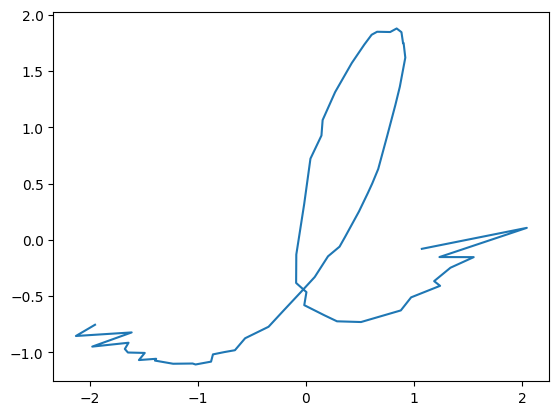

In [53]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [54]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'rectangle', 'delete_mark', 'check', 'circle', 'pigtail'}
{0, 1, 2, 3, 4}
5
(1280, 64, 2) (320, 64, 2) (1280, 5) (320, 5)


In [55]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates

# old syntax
#model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

# new syntax
model.add(Input((NUM_POINTS, 2)))
model.add(LSTM(UNITS))

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [56]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.2783 - loss: 1.5754 - val_accuracy: 0.5906 - val_loss: 1.3865 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6526 - loss: 1.2900 - val_accuracy: 0.7719 - val_loss: 0.9473 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8241 - loss: 0.7953 - val_accuracy: 0.9312 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9541 - loss: 0.3345 - val_accuracy: 0.9625 - val_loss: 0.1774 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9736 - loss: 0.1332 - val_accuracy: 0.9812 - val_loss: 0.0873 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9861 - loss: 0.0790 - val_accuracy: 0.9937 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9935 - loss: 0.0476 - val_a

In [57]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 16)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,777 (22.57 KB)

 Trainable params: 1,925 (7.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,852 (15.05 KB)

In [58]:
model.save(f'./{UNITS}_units.keras')

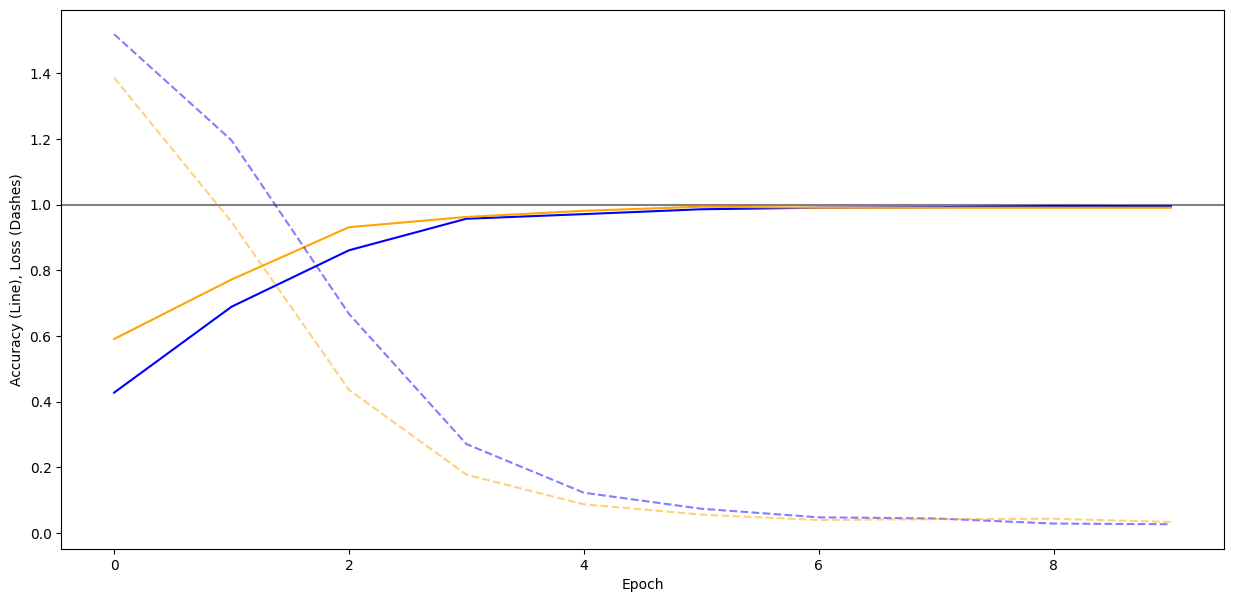

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


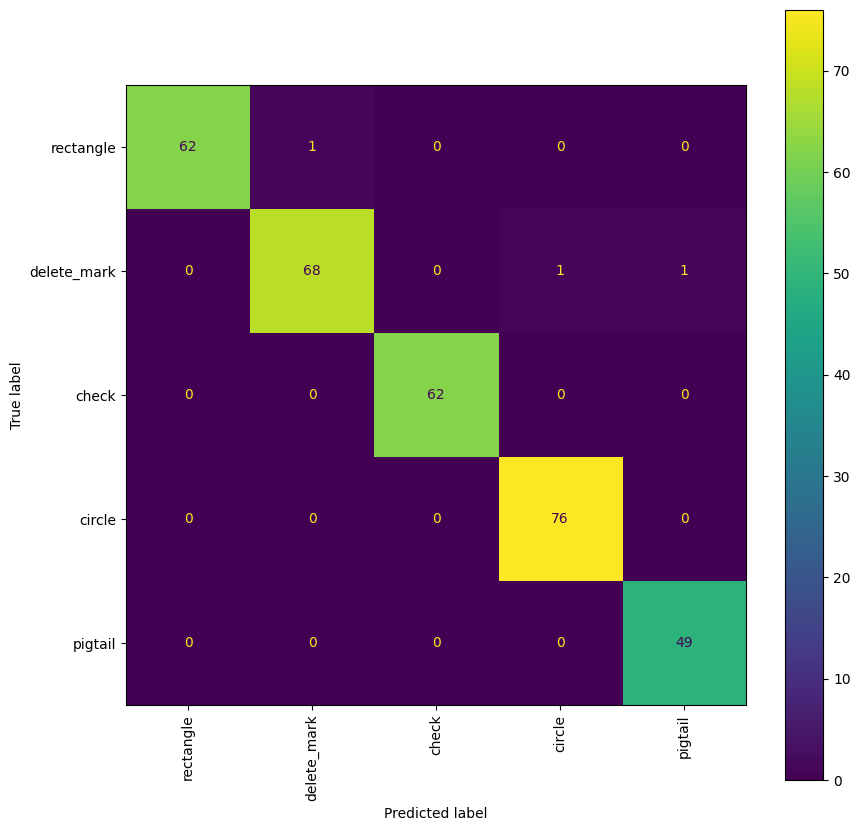

In [60]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
Label:      circle
Prediction: circle


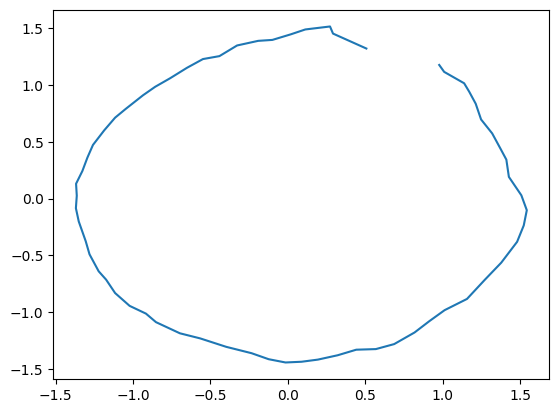

In [61]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)